In [ ]:
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0
#clone github repository
!git clone https://github.com/open-mmlab/mmsegmentation.git 
#install all requirements
!pip install -qr mmsegmentation/requirements.txt 
%cd /content/mmsegmentation
#install mmsegmentation in develop mode
!python setup.py develop

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#DataPath and DataCustomize

In [3]:
#declare global variables
root_dir= '/content/mmsegmentation/data/'
data_root= "/content/mmsegmentation/data/"

dataset= "my_dataset"


In [4]:
import os

#check file counts
train_imgs= data_root + dataset+'/img_dir/train'
val_imgs= data_root + dataset +'/img_dir/val'
train_gt= data_root + dataset+'/ann_dir/train'
val_gt= data_root + dataset+'/ann_dir/val'

#print the file count
print(len(os.listdir(train_imgs)))
print(len(os.listdir(val_imgs)))
print(len(os.listdir(train_gt)))
print(len(os.listdir(val_gt)))

36
4
36
4


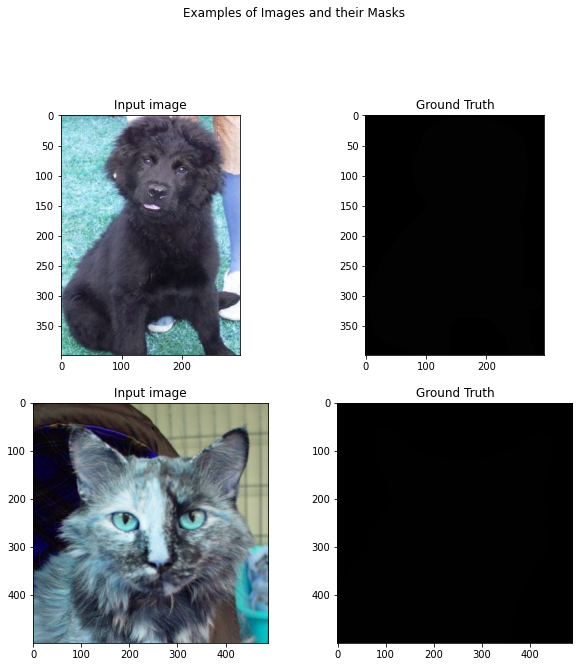

In [7]:
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob


PATH_TO_TRAIN_IMAGES_DIR= data_root+dataset+'/img_dir/train'
PATH_TO_LABEL_IMAGES_DIR= data_root+dataset+'/ann_dir/train'

TRAIN_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TRAIN_IMAGES_DIR, "*.jpg"))
LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png"))

TRAIN_IMAGE_PATHS.sort()
LABEL_PATHS.sort()

palette = [[128, 0, 128], [128, 0, 0], [255,255,77]] #dataset palette

display_num = 3
r_choices = np.random.choice(len(TRAIN_IMAGE_PATHS), display_num)

#visualize any 5 random images and their mask images
plt.figure(figsize=(10, 15))
for i in range(0, display_num, 2):
  img_num = r_choices[i // 2]
  img = mmcv.imread(TRAIN_IMAGE_PATHS[img_num])
  label = mmcv.imread(LABEL_PATHS[img_num])

  plt.subplot(display_num, 2, i + 1)
  plt.imshow(img)
  plt.title("Input image")

  plt.subplot(display_num, 2, i + 2)
  plt.imshow(label)
  plt.title("Ground Truth")


plt.suptitle("Examples of Images and their Masks")
plt.show()

# MMSeg

In [17]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [18]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device
import torch

cfg_data_root = data_root+dataset
train_img_dir = 'img_dir/train'
train_ann_dir = 'ann_dir/train'
val_img_dir = 'img_dir/val'
val_ann_dir = 'ann_dir/val'

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes =3

# Modify dataset type and path
cfg.dataset_type = 'CustomDataset'
cfg.data_root = cfg_data_root

#batch size
cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu=4

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = train_img_dir
cfg.data.train.ann_dir = train_ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = None

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = val_img_dir
cfg.data.val.ann_dir = val_ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = None

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = val_img_dir
cfg.data.test.ann_dir = val_ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = None


# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 400
cfg.log_config.interval = 50
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

In [19]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import os.path as osp

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-07-28 15:30:16,073 - mmseg - INFO - Loaded 36 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, low

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 7.7 task/s, elapsed: 1s, ETA:     0s

2022-07-28 15:32:12,477 - mmseg - INFO - per class results:
2022-07-28 15:32:12,479 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| BackGround | 48.15 | 55.89 |
|    Cat     |  0.0  |  0.0  |
|    Dog     | 30.41 | 79.64 |
+------------+-------+-------+
2022-07-28 15:32:12,482 - mmseg - INFO - Summary:
2022-07-28 15:32:12,486 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 52.62 | 26.19 | 45.18 |
+-------+-------+-------+
2022-07-28 15:32:12,488 - mmseg - INFO - Iter(val) [4]	aAcc: 0.5262, mIoU: 0.2619, mAcc: 0.4518, IoU.BackGround: 0.4815, IoU.Cat: 0.0000, IoU.Dog: 0.3041, Acc.BackGround: 0.5589, Acc.Cat: 0.0000, Acc.Dog: 0.7964
2022-07-28 15:32:39,168 - mmseg - INFO - Iter [250/400]	lr: 4.220e-03, eta: 0:01:25, time: 0.544, data_time: 0.223, memory: 2230, decode.loss_ce: 0.8165, decode.acc_seg: 52.7618, aux.loss_ce: 0.3351, aux.acc_seg: 49.4512, loss: 1.1516
2022-07-28 1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 13.9 task/s, elapsed: 0s, ETA:     0s

2022-07-28 15:34:07,273 - mmseg - INFO - per class results:
2022-07-28 15:34:07,274 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| BackGround | 68.28 |  83.4 |
|    Cat     | 46.42 | 75.48 |
|    Dog     | 46.36 | 50.56 |
+------------+-------+-------+
2022-07-28 15:34:07,278 - mmseg - INFO - Summary:
2022-07-28 15:34:07,282 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.53 | 53.69 | 69.81 |
+-------+-------+-------+
2022-07-28 15:34:07,285 - mmseg - INFO - Iter(val) [4]	aAcc: 0.7453, mIoU: 0.5369, mAcc: 0.6981, IoU.BackGround: 0.6828, IoU.Cat: 0.4642, IoU.Dog: 0.4636, Acc.BackGround: 0.8340, Acc.Cat: 0.7548, Acc.Dog: 0.5056


4


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


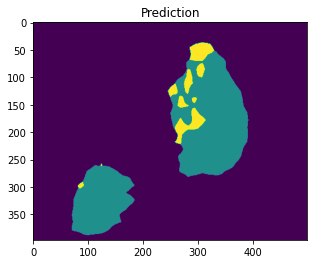

<Figure size 576x432 with 0 Axes>

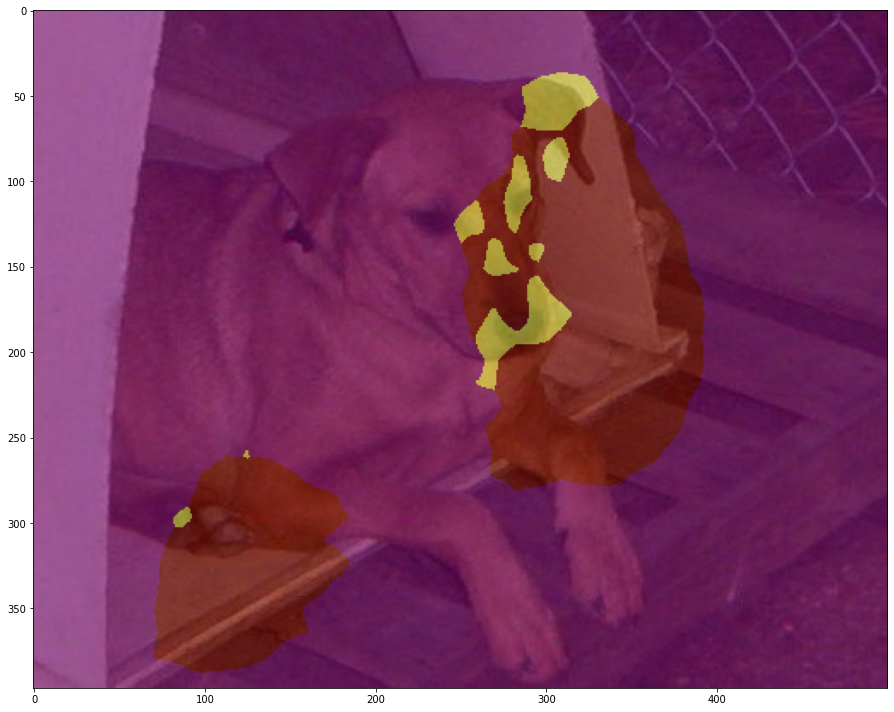

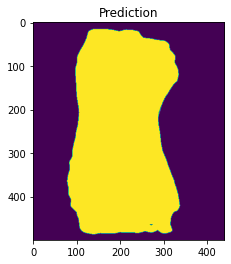

<Figure size 576x432 with 0 Axes>

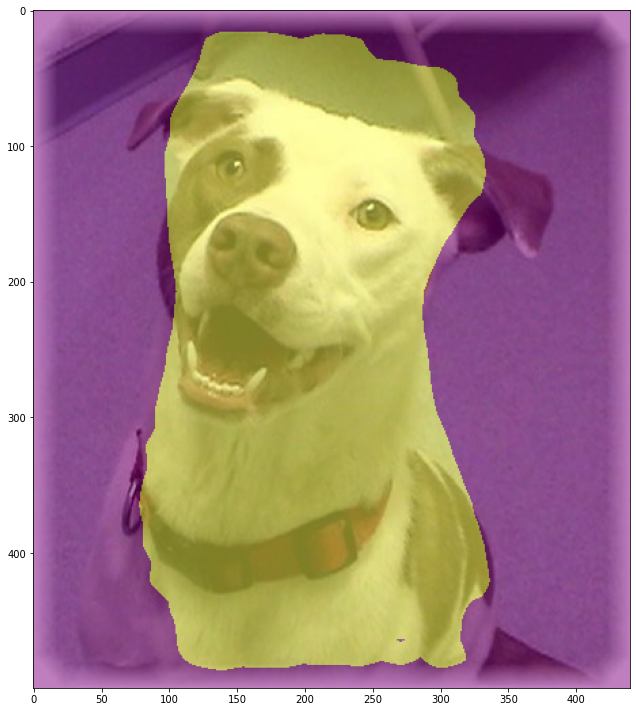

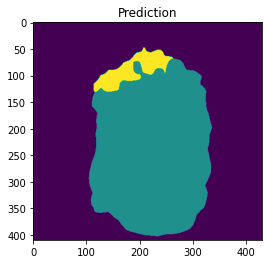

<Figure size 576x432 with 0 Axes>

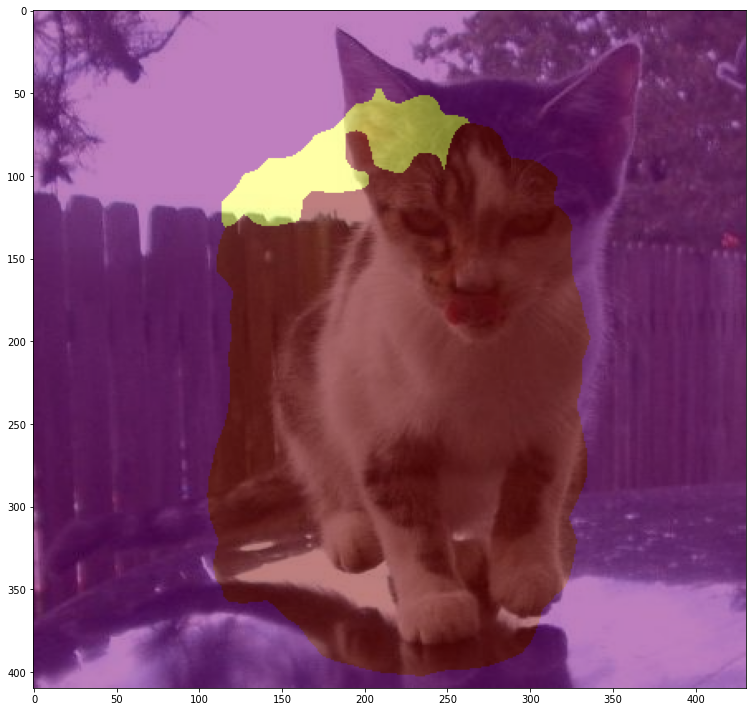

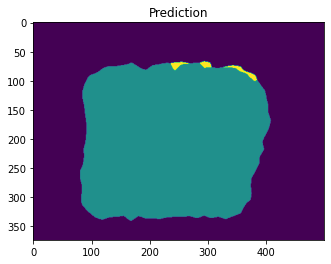

<Figure size 576x432 with 0 Axes>

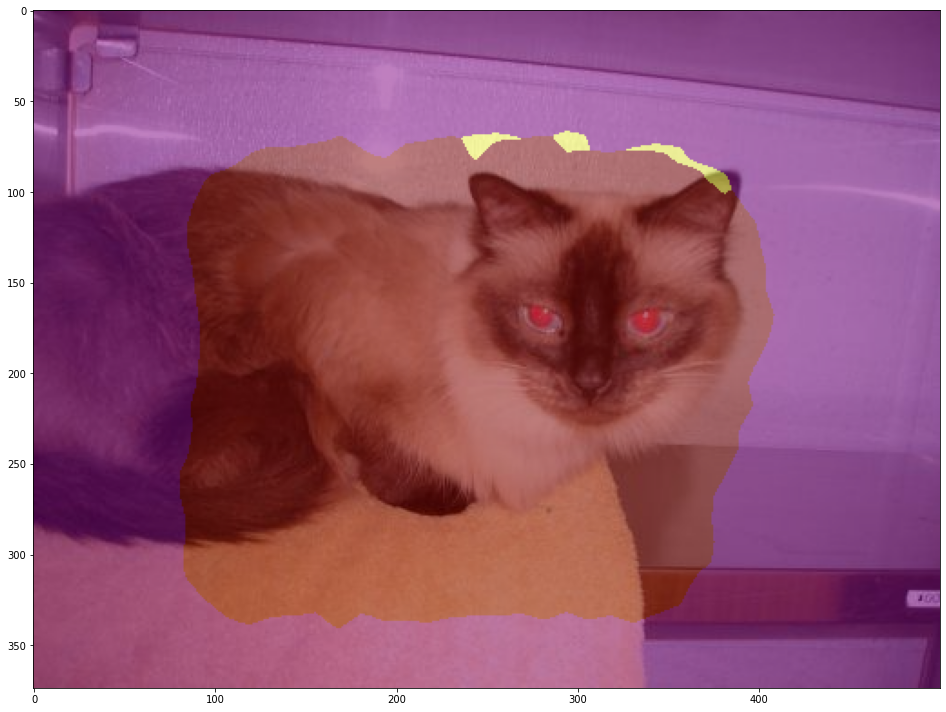

In [23]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob
import zipfile

PATH_TO_TEST_IMAGES_DIR= data_root+dataset+"/img_dir/val"

PATH_TO_LABEL_IMAGES_DIR= data_root+dataset+"/ann_dir/val"
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png"))

TEST_IMAGE_PATHS.sort()
LABEL_PATHS.sort()

checkpoint= 'work_dirs/tutorial/iter_400.pth' #checkpoint path
#model = init_segmentor(cfg, checkpoint, device='cuda:0')
model.cfg = cfg

palette = [[128, 0, 128], [128, 0, 0], [255,255,77]] # purple - maroon- ffff4d(yellow) 
#120, 120, 120
print(len(TEST_IMAGE_PATHS))

for i in range(0, len(TEST_IMAGE_PATHS)):
  img = mmcv.imread(TEST_IMAGE_PATHS[i])
  label = mmcv.imread(LABEL_PATHS[i])
  result = inference_segmentor(model, img)
  img_name= LABEL_PATHS[i].split("/")[3] #FOR MASK
  arr= np.array(result)
  arr=np.squeeze(arr)


  plt.imshow(arr)
  plt.title("Prediction")


  

  plt.figure(figsize=(8, 6))
  show_result_pyplot(model, img, result,palette)